# EDA Final Project - Chicago Crime and COVID-19 rates 

## 11/28/2020

### Written by Elizabeth Beiler 

### History
* Read in CSV
* API
* Data Cleansing
* Merge CSVs into one new dataframe
* Statistics and outliers
* Boxplot
* Data Visuals
* Reporting

**Project Objective: Prove or disprove my hpothesis which states, as COVID-19 cases have risen in Chicago, crime rates have also risen.  Specifically crime types such as:**
1. Domestic Violence
2. Aggravated Assault
3. Theft 
4. Home Invasions
5. Gun Confiscations/Weapons
6. Murder
7. Shootings

Import necessary libraries 

In [324]:
##Begin all scripts by first importing all necessary libraries nedded for the script.
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import re
import plotly as py
import plotly.express as px
import requests
import json
from os import listdir
from datetime import timedelta
from pandas.io.json import json_normalize
import datetime as dt
import itertools
import collections
from pathlib import Path 
from sodapy import Socrata
import statsmodels.api as sm

Read in COVID dataset 

In [284]:
##Read in the CSV file for COVID rates and create a data frame called dfcovid
dfcovid = pd.read_csv(r"C:\Users\elizb\Desktop\Northwestern Grad Program\MSDS430 Python for Data Analytics - Bader\EDA\Project\COVID-19_Daily_Cases__Deaths__and_Hospitalizations Nov 2020.csv")

In [285]:
##Check the first five rows of the df to ensure it read in correctly.  
dfcovid.head(2)

,Date,Cases - Total,Deaths - Total,Hospitalizations - Total,Cases - Age 0-17,Cases - Age 18-29,Cases - Age 30-39,Cases - Age 40-49,Cases - Age 50-59,Cases - Age 60-69,...,Hospitalizations - Age Unknown,Hospitalizations - Female,Hospitalizations - Male,Hospitalizations - Unknown Gender,Hospitalizations - Latinx,Hospitalizations - Asian Non-Latinx,Hospitalizations - Black Non-Latinx,Hospitalizations - White Non-Latinx,Hospitalizations - Other Race Non-Latinx,Hospitalizations - Unknown Race/Ethnicity
0,03/29/2020,282,20,130.0,4,29,48,54,50,50,...,0.0,57.0,73.0,0.0,21.0,3.0,92.0,11.0,2.0,1.0
1,03/01/2020,0,0,2.0,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


    Set up SODAPI and download Crime data set 
    
    SODAPI doumentation 
    https://pypi.org/project/sodapy/

In [233]:
##Set up Chicago Data Portal API for crime data 
def download_dataset(domain, dataset_id):
    # for this exercise, we're not using an app token,
    client = Socrata(domain, app_token=None)
    offset = None
    data = []
    batch_size = 1000
    
    while True:
        records = client.get(dataset_id, offset=offset, limit=batch_size, where="year >= 2018")
        data.extend(records)
        if len(records) < batch_size:
            break
        offset = offset + batch_size if (offset) else batch_size

    return pd.DataFrame.from_dict(data)

# Note - uncomment the next line to force a data refresh
#del crime_data_df

def download_crime_dataset():
    return crime_data_df if "crime_data_df" in globals() else download_dataset("Data.cityofchicago.org", "ijzp-q8t2")
    
# load crime 2001-2020 data
crime_data_df = download_crime_dataset()

In [235]:
print(len(crime_data_df))
crime_data_df.info()

715786
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715786 entries, 0 to 715785
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    715786 non-null  object
 1   case_number           715786 non-null  object
 2   date                  715786 non-null  object
 3   block                 715786 non-null  object
 4   iucr                  715786 non-null  object
 5   primary_type          715786 non-null  object
 6   description           715786 non-null  object
 7   location_description  712668 non-null  object
 8   arrest                715786 non-null  bool  
 9   domestic              715786 non-null  bool  
 10  beat                  715786 non-null  object
 11  district              715786 non-null  object
 12  ward                  715758 non-null  object
 13  community_area        715786 non-null  object
 14  fbi_code              715786 non-null  object
 15  x_coordina

In [236]:
##get just the crime data we care about - id qzdf-xmn8
client.get("ijzp-q8t2", limit=2)

[{'id': '12226357',
  'case_number': 'JD437401',
  'date': '2020-11-20T23:58:00.000',
  'block': '069XX S WESTERN AVE',
  'iucr': '2027',
  'primary_type': 'NARCOTICS',
  'description': 'POSSESS - CRACK',
  'location_description': 'STREET',
  'arrest': True,
  'domestic': False,
  'beat': '0832',
  'district': '008',
  'ward': '17',
  'community_area': '66',
  'fbi_code': '18',
  'year': '2020',
  'updated_on': '2020-11-27T15:47:59.000'},
 {'id': '12226445',
  'case_number': 'JD437393',
  'date': '2020-11-20T23:45:00.000',
  'block': '069XX S PRAIRIE AVE',
  'iucr': '1310',
  'primary_type': 'CRIMINAL DAMAGE',
  'description': 'TO PROPERTY',
  'location_description': 'RESIDENCE',
  'arrest': False,
  'domestic': False,
  'beat': '0322',
  'district': '003',
  'ward': '6',
  'community_area': '69',
  'fbi_code': '14',
  'year': '2020',
  'updated_on': '2020-11-27T15:47:59.000'}]

In [286]:
dfcrime = crime_data_df
dfcrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715786 entries, 0 to 715785
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    715786 non-null  object
 1   case_number           715786 non-null  object
 2   date                  715786 non-null  object
 3   block                 715786 non-null  object
 4   iucr                  715786 non-null  object
 5   primary_type          715786 non-null  object
 6   description           715786 non-null  object
 7   location_description  712668 non-null  object
 8   arrest                715786 non-null  bool  
 9   domestic              715786 non-null  bool  
 10  beat                  715786 non-null  object
 11  district              715786 non-null  object
 12  ward                  715758 non-null  object
 13  community_area        715786 non-null  object
 14  fbi_code              715786 non-null  object
 15  x_coordinate     

In [287]:
##Found data IDs via URL, used client get to see if the data set was available via the SODAPI

##Get just the covid data we care about - id kxzd-kd6a 
##client.get("kxzd-kd6a", limit=2)
##Covid dataset not available through SODAPI

##get just the crime data we care about - id qzdf-xmn8
##client.get("qzdf-xmn8", limit=2)

Cleanse the data 

In [288]:
#Get a count of the N/As in the COVID dataframe 
covid_count = dfcovid.isna().sum()
covid_count

Date                                         1
Cases - Total                                0
Deaths - Total                               0
Hospitalizations - Total                     5
Cases - Age 0-17                             0
Cases - Age 18-29                            0
Cases - Age 30-39                            0
Cases - Age 40-49                            0
Cases - Age 50-59                            0
Cases - Age 60-69                            0
Cases - Age 70-79                            0
Cases -  Age 80+                             0
Cases - Age Unknown                          0
Cases - Female                               0
Cases - Male                                 0
Cases - Unknown Gender                       0
Cases - Latinx                               0
Cases - Asian Non-Latinx                     0
Cases - Black Non-Latinx                     0
Cases - White Non-Latinx                     0
Cases - Other Race Non-Latinx                0
Cases - Unkno

In [289]:
##Drop the N/As from the columns in the COVID dataframe
dfcovid = dfcovid.dropna()
dfcovid.isna().sum()

Date                                         0
Cases - Total                                0
Deaths - Total                               0
Hospitalizations - Total                     0
Cases - Age 0-17                             0
Cases - Age 18-29                            0
Cases - Age 30-39                            0
Cases - Age 40-49                            0
Cases - Age 50-59                            0
Cases - Age 60-69                            0
Cases - Age 70-79                            0
Cases -  Age 80+                             0
Cases - Age Unknown                          0
Cases - Female                               0
Cases - Male                                 0
Cases - Unknown Gender                       0
Cases - Latinx                               0
Cases - Asian Non-Latinx                     0
Cases - Black Non-Latinx                     0
Cases - White Non-Latinx                     0
Cases - Other Race Non-Latinx                0
Cases - Unkno

In [290]:
##Check for null values in the COVID dataframe
dfcovid.isnull().sum()

Date                                         0
Cases - Total                                0
Deaths - Total                               0
Hospitalizations - Total                     0
Cases - Age 0-17                             0
Cases - Age 18-29                            0
Cases - Age 30-39                            0
Cases - Age 40-49                            0
Cases - Age 50-59                            0
Cases - Age 60-69                            0
Cases - Age 70-79                            0
Cases -  Age 80+                             0
Cases - Age Unknown                          0
Cases - Female                               0
Cases - Male                                 0
Cases - Unknown Gender                       0
Cases - Latinx                               0
Cases - Asian Non-Latinx                     0
Cases - Black Non-Latinx                     0
Cases - White Non-Latinx                     0
Cases - Other Race Non-Latinx                0
Cases - Unkno

In [291]:
##Do the same N/A and null cleanup for the Crime dataframe
dfcrime.isna().sum()

id                          0
case_number                 0
date                        0
block                       0
iucr                        0
primary_type                0
description                 0
location_description     3118
arrest                      0
domestic                    0
beat                        0
district                    0
ward                       28
community_area              0
fbi_code                    0
x_coordinate            29113
y_coordinate            29113
year                        0
updated_on                  0
latitude                29113
longitude               29113
location                29113
dtype: int64

In [292]:
##Drop the N/As from the columns in the Crime dataframe
dfcrime = dfcrime.dropna()
dfcrime.isna().sum()

id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [293]:
dfcrime.isnull().sum()

id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [294]:
##Check for duplicates in COVID dataframe
dfcovid.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
245    False
246    False
247    False
248    False
249    False
Length: 244, dtype: bool

In [295]:
##Check for duplicates in Crime dataframe
dfcrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684281 entries, 0 to 715785
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    684281 non-null  object
 1   case_number           684281 non-null  object
 2   date                  684281 non-null  object
 3   block                 684281 non-null  object
 4   iucr                  684281 non-null  object
 5   primary_type          684281 non-null  object
 6   description           684281 non-null  object
 7   location_description  684281 non-null  object
 8   arrest                684281 non-null  bool  
 9   domestic              684281 non-null  bool  
 10  beat                  684281 non-null  object
 11  district              684281 non-null  object
 12  ward                  684281 non-null  object
 13  community_area        684281 non-null  object
 14  fbi_code              684281 non-null  object
 15  x_coordinate     

In [296]:
##Check columns in COVID df to see what we can remove 
dfcovid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 249
Data columns (total 58 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Date                                       244 non-null    object 
 1   Cases - Total                              244 non-null    int64  
 2   Deaths - Total                             244 non-null    int64  
 3   Hospitalizations - Total                   244 non-null    float64
 4   Cases - Age 0-17                           244 non-null    int64  
 5   Cases - Age 18-29                          244 non-null    int64  
 6   Cases - Age 30-39                          244 non-null    int64  
 7   Cases - Age 40-49                          244 non-null    int64  
 8   Cases - Age 50-59                          244 non-null    int64  
 9   Cases - Age 60-69                          244 non-null    int64  
 10  Cases - Age 70-79         

In [297]:
dfcovid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 249
Data columns (total 58 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Date                                       244 non-null    object 
 1   Cases - Total                              244 non-null    int64  
 2   Deaths - Total                             244 non-null    int64  
 3   Hospitalizations - Total                   244 non-null    float64
 4   Cases - Age 0-17                           244 non-null    int64  
 5   Cases - Age 18-29                          244 non-null    int64  
 6   Cases - Age 30-39                          244 non-null    int64  
 7   Cases - Age 40-49                          244 non-null    int64  
 8   Cases - Age 50-59                          244 non-null    int64  
 9   Cases - Age 60-69                          244 non-null    int64  
 10  Cases - Age 70-79         

In [300]:
##Drop columns with unknown and other not needed in dfcovid that I missed
dfcovid = dfcovid.drop(["Deaths - Unknown Gender", "Deaths - Age Unknown", "Cases - Unknown Race/Ethnicity", "Cases - Age Unknown"], axis=1)


In [301]:
dfcrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684281 entries, 0 to 715785
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    684281 non-null  object
 1   case_number           684281 non-null  object
 2   date                  684281 non-null  object
 3   block                 684281 non-null  object
 4   iucr                  684281 non-null  object
 5   primary_type          684281 non-null  object
 6   description           684281 non-null  object
 7   location_description  684281 non-null  object
 8   arrest                684281 non-null  bool  
 9   domestic              684281 non-null  bool  
 10  beat                  684281 non-null  object
 11  district              684281 non-null  object
 12  ward                  684281 non-null  object
 13  community_area        684281 non-null  object
 14  fbi_code              684281 non-null  object
 15  x_coordinate     

In [302]:
dfcrime = dfcrime.drop(["ward", "block", "updated_on", "community_area", "location_description", "case_number", "beat", "id", "location", "longitude", "x_coordinate", "y_coordinate", "latitude"], axis=1)

In [303]:
dfcrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684281 entries, 0 to 715785
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          684281 non-null  object
 1   iucr          684281 non-null  object
 2   primary_type  684281 non-null  object
 3   description   684281 non-null  object
 4   arrest        684281 non-null  bool  
 5   domestic      684281 non-null  bool  
 6   district      684281 non-null  object
 7   fbi_code      684281 non-null  object
 8   year          684281 non-null  object
dtypes: bool(2), object(7)
memory usage: 43.1+ MB


In [304]:
##Change data type for year from object to string 
dfcrime['year'] = dfcrime['year'].astype(str)

In [305]:
##Check the value counts for 2018, 2019, 2020
dfcrime["year"].value_counts()

2018    262789
2019    258156
2020    163336
Name: year, dtype: int64

In [306]:
##Change the data formats for crime dataframe
dfcrime['date'] = pd.to_datetime(dfcrime['date']).dt.date

In [307]:
dfcrime.head(2)

,date,iucr,primary_type,description,arrest,domestic,district,fbi_code,year
0,2018-08-20,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,False,True,014,17,2018
1,2018-10-14,031A,ROBBERY,ARMED - HANDGUN,True,False,018,03,2018


In [308]:
dfcrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684281 entries, 0 to 715785
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          684281 non-null  object
 1   iucr          684281 non-null  object
 2   primary_type  684281 non-null  object
 3   description   684281 non-null  object
 4   arrest        684281 non-null  bool  
 5   domestic      684281 non-null  bool  
 6   district      684281 non-null  object
 7   fbi_code      684281 non-null  object
 8   year          684281 non-null  object
dtypes: bool(2), object(7)
memory usage: 43.1+ MB


In [309]:
dfcovid.head(2)

,Date,Cases - Total,Deaths - Total,Hospitalizations - Total,Cases - Age 0-17,Cases - Age 18-29,Cases - Age 30-39,Cases - Age 40-49,Cases - Age 50-59,Cases - Age 60-69,...,Hospitalizations - Age Unknown,Hospitalizations - Female,Hospitalizations - Male,Hospitalizations - Unknown Gender,Hospitalizations - Latinx,Hospitalizations - Asian Non-Latinx,Hospitalizations - Black Non-Latinx,Hospitalizations - White Non-Latinx,Hospitalizations - Other Race Non-Latinx,Hospitalizations - Unknown Race/Ethnicity
0,03/29/2020,282,20,130.0,4,29,48,54,50,50,...,0.0,57.0,73.0,0.0,21.0,3.0,92.0,11.0,2.0,1.0
1,03/01/2020,0,0,2.0,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [310]:
##Change the data formats for covid 
dfcovid['Date'] = pd.to_datetime(dfcovid['Date']).dt.date

In [311]:
dfcovid.head(2)

,Date,Cases - Total,Deaths - Total,Hospitalizations - Total,Cases - Age 0-17,Cases - Age 18-29,Cases - Age 30-39,Cases - Age 40-49,Cases - Age 50-59,Cases - Age 60-69,...,Hospitalizations - Age Unknown,Hospitalizations - Female,Hospitalizations - Male,Hospitalizations - Unknown Gender,Hospitalizations - Latinx,Hospitalizations - Asian Non-Latinx,Hospitalizations - Black Non-Latinx,Hospitalizations - White Non-Latinx,Hospitalizations - Other Race Non-Latinx,Hospitalizations - Unknown Race/Ethnicity
0,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,0.0,57.0,73.0,0.0,21.0,3.0,92.0,11.0,2.0,1.0
1,2020-03-01,0,0,2.0,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


Merge the dataframes 

In [314]:
##Create another data frame called result which merges the covid table and the crime table. We have to specify what kind of join we want to do using the how
result = pd.merge(dfcovid, dfcrime[["date", "iucr", "primary_type", "description", "arrest", "domestic", "fbi_code", "year"]], left_on ='Date', right_on = "date", how ='inner')

In [315]:
result.head(2)

,Date,Cases - Total,Deaths - Total,Hospitalizations - Total,Cases - Age 0-17,Cases - Age 18-29,Cases - Age 30-39,Cases - Age 40-49,Cases - Age 50-59,Cases - Age 60-69,...,Hospitalizations - Other Race Non-Latinx,Hospitalizations - Unknown Race/Ethnicity,date,iucr,primary_type,description,arrest,domestic,fbi_code,year
0,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,2.0,1.0,2020-03-29,0610,BURGLARY,FORCIBLE ENTRY,False,False,05,2020
1,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,2.0,1.0,2020-03-29,1365,CRIMINAL TRESPASS,TO RESIDENCE,True,False,26,2020


In [316]:
result.drop(['date'], axis=1)

,Date,Cases - Total,Deaths - Total,Hospitalizations - Total,Cases - Age 0-17,Cases - Age 18-29,Cases - Age 30-39,Cases - Age 40-49,Cases - Age 50-59,Cases - Age 60-69,...,Hospitalizations - White Non-Latinx,Hospitalizations - Other Race Non-Latinx,Hospitalizations - Unknown Race/Ethnicity,iucr,primary_type,description,arrest,domestic,fbi_code,year
0,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,11.0,2.0,1.0,0610,BURGLARY,FORCIBLE ENTRY,False,False,05,2020
1,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,11.0,2.0,1.0,1365,CRIMINAL TRESPASS,TO RESIDENCE,True,False,26,2020
2,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,11.0,2.0,1.0,1152,DECEPTIVE PRACTICE,ILLEGAL USE CASH CARD,False,False,11,2020
3,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,11.0,2.0,1.0,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,False,False,11,2020
4,2020-03-29,282,20,130.0,4,29,48,54,50,50,...,11.0,2.0,1.0,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,False,False,11,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126020,2020-05-04,1120,48,126.0,57,218,223,243,177,109,...,18.0,9.0,5.0,2024,NARCOTICS,POSSESS - HEROIN (WHITE),True,False,18,2020
126021,2020-05-04,1120,48,126.0,57,218,223,243,177,109,...,18.0,9.0,5.0,0530,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,False,False,04A,2020
126022,2020-05-04,1120,48,126.0,57,218,223,243,177,109,...,18.0,9.0,5.0,041A,BATTERY,AGGRAVATED - HANDGUN,False,False,04B,2020
126023,2020-05-04,1120,48,126.0,57,218,223,243,177,109,...,18.0,9.0,5.0,0486,BATTERY,DOMESTIC BATTERY SIMPLE,False,True,08B,2020


Statsistics and Outliers

In [317]:
result.describe()

,Cases - Total,Deaths - Total,Hospitalizations - Total,Cases - Age 0-17,Cases - Age 18-29,Cases - Age 30-39,Cases - Age 40-49,Cases - Age 50-59,Cases - Age 60-69,Cases - Age 70-79,...,Hospitalizations - Age Unknown,Hospitalizations - Female,Hospitalizations - Male,Hospitalizations - Unknown Gender,Hospitalizations - Latinx,Hospitalizations - Asian Non-Latinx,Hospitalizations - Black Non-Latinx,Hospitalizations - White Non-Latinx,Hospitalizations - Other Race Non-Latinx,Hospitalizations - Unknown Race/Ethnicity
count,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,...,126025.0,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000,126025.000000
mean,359.057028,11.970982,52.033485,28.853418,84.755668,67.877183,59.325015,51.933632,35.222131,18.243134,...,0.0,24.310065,27.495537,0.227883,15.835406,1.310637,22.429121,8.298187,2.351113,1.809022
std,268.527377,14.193044,50.168176,21.567884,55.655040,49.717934,50.611665,47.105549,34.024577,18.755336,...,0.0,22.153355,28.273031,0.730740,16.046378,1.913422,24.551465,7.577505,3.310104,2.093539
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,2.000000,22.000000,11.000000,40.000000,30.000000,28.000000,24.000000,15.000000,7.000000,...,0.0,11.000000,10.000000,0.000000,6.000000,0.000000,8.000000,3.000000,0.000000,0.000000
50%,330.000000,4.000000,29.000000,24.000000,83.000000,65.000000,48.000000,39.000000,24.000000,12.000000,...,0.0,15.000000,14.000000,0.000000,10.000000,1.000000,11.000000,5.000000,1.000000,1.000000
75%,427.000000,21.000000,63.000000,47.000000,117.000000,84.000000,67.000000,64.000000,39.000000,21.000000,...,0.0,28.000000,35.000000,0.000000,17.000000,2.000000,27.000000,10.000000,3.000000,2.000000
max,1783.000000,57.000000,202.000000,233.000000,507.000000,406.000000,289.000000,248.000000,244.000000,161.000000,...,0.0,109.000000,108.000000,6.000000,66.000000,10.000000,113.000000,36.000000,15.000000,13.000000


In [319]:
result.shape

(126025, 62)

In [325]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126025 entries, 0 to 126024
Data columns (total 62 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Date                                       126025 non-null  object 
 1   Cases - Total                              126025 non-null  int64  
 2   Deaths - Total                             126025 non-null  int64  
 3   Hospitalizations - Total                   126025 non-null  float64
 4   Cases - Age 0-17                           126025 non-null  int64  
 5   Cases - Age 18-29                          126025 non-null  int64  
 6   Cases - Age 30-39                          126025 non-null  int64  
 7   Cases - Age 40-49                          126025 non-null  int64  
 8   Cases - Age 50-59                          126025 non-null  int64  
 9   Cases - Age 60-69                          126025 non-null  int64  
 10  Cases - 

In [339]:
primcount = result.primary_type.value_counts()
primcount

BATTERY                              26853
THEFT                                23837
CRIMINAL DAMAGE                      16454
ASSAULT                              11881
OTHER OFFENSE                         7219
DECEPTIVE PRACTICE                    6877
MOTOR VEHICLE THEFT                   6137
BURGLARY                              5779
WEAPONS VIOLATION                     5458
ROBBERY                               4769
NARCOTICS                             3226
CRIMINAL TRESPASS                     2309
OFFENSE INVOLVING CHILDREN            1024
PUBLIC PEACE VIOLATION                 932
CRIMINAL SEXUAL ASSAULT                673
HOMICIDE                               595
SEX OFFENSE                            530
ARSON                                  415
INTERFERENCE WITH PUBLIC OFFICER       322
PROSTITUTION                           197
STALKING                               115
INTIMIDATION                           107
CONCEALED CARRY LICENSE VIOLATION       93
LIQUOR LAW 

In [ ]:
#Adding in linear regression component 

In [321]:
##Adding in statistical hypothesis testing component

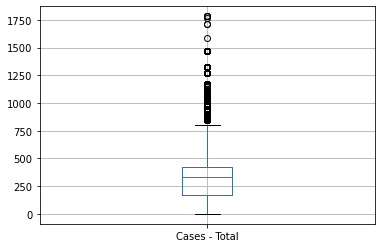

In [341]:
##Adding boxplot for total cases of covid 
result.boxplot(column ='Cases - Total')

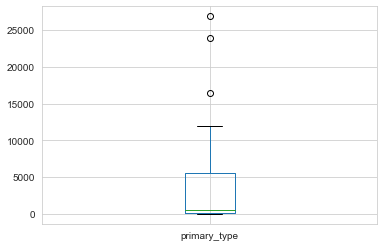

In [349]:
##Adding boxplot for pimary crime type count 
primcount.to_frame().boxplot()

Data Visualization 

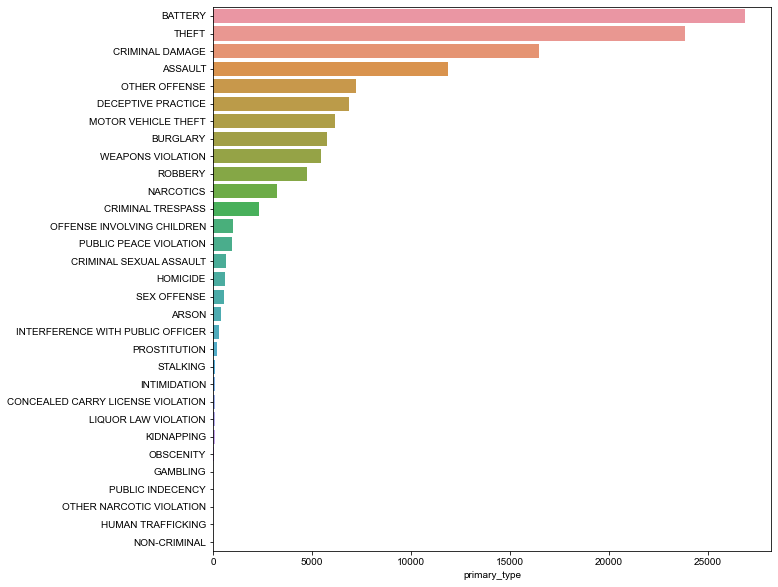

In [342]:
dfcrime_types = result['primary_type'].value_counts().to_frame()
fig = plt.figure(figsize=(10,10))
crimetype_bar_plot = sns.barplot(x='primary_type', y=dfcrime_types.index, data=dfcrime_types)
sns.set_context(font_scale=50, rc={"font.size":10, "axes.labelsize":15})
sns.set_style("whitegrid")
plt.show()